# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
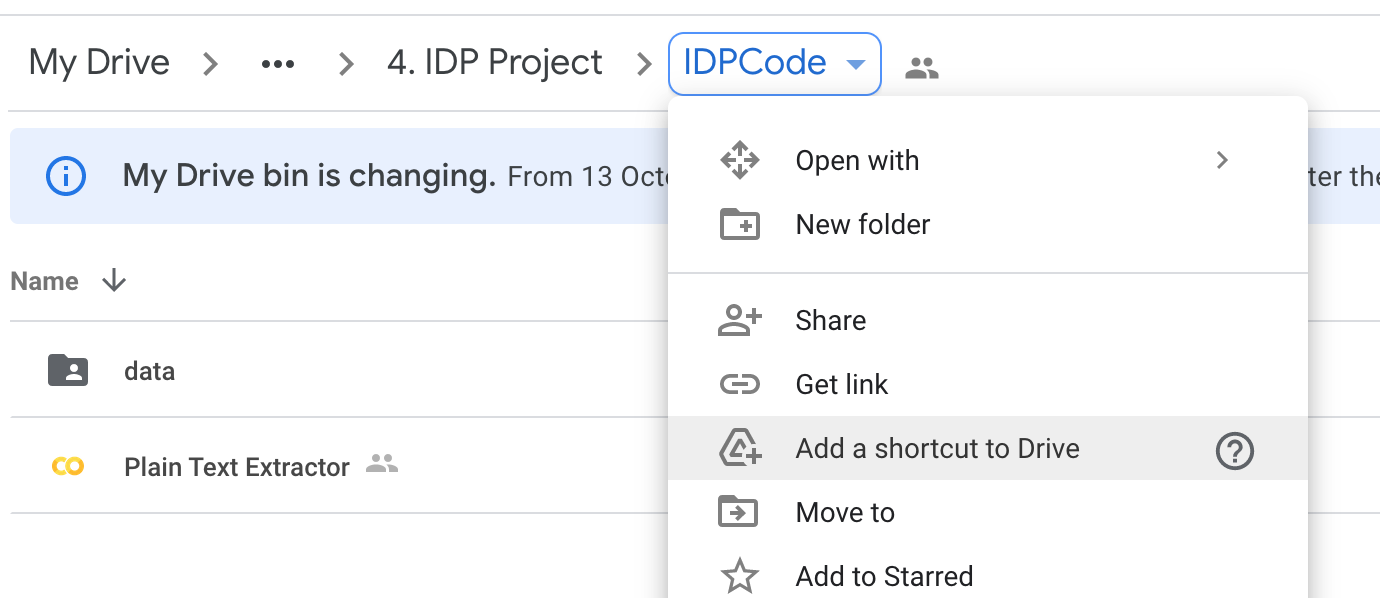
2. Run the command below to connect the GDrive:


In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

In [ ]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5
!pip install textacy
!pip install spacy-langdetect
!pip install pandarallel

# Start from here if you run in local !!

In [85]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/FC/GoogleDrive/AllPapers'


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 61.6 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [86]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
    
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')

def run_in_parallel(dt, function, n_cores=8):
    df_n = np.array_split(df, n_cores)

    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_n))
    pool.close()
    pool.join()
    return df

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<>:8: DeprecationWarning:

invalid escape sequence \$

<>:26: DeprecationWarning:

invalid escape sequence \/

<>:30: DeprecationWarning:

invalid escape sequence \w

<>:8: DeprecationWarning:

invalid escape sequence \$

<>:26: DeprecationWarning:

invalid escape sequence \/

<>:30: DeprecationWarning:

invalid escape sequence \w

<ipython-input-86-3936c85155c4>:8: DeprecationWarning:

invalid escape sequence \$

<ipython-input-86-3936c85155c4>:26: DeprecationWarning:

invalid escape sequence \/

<ipython-input-86-3936c85155c4>:30: DeprecationWarning:

invalid escape sequence \w



time: 6.05 s


# Initial Info about the dataset
The dataset in 'All_Papers_In_Plain_Text_TIKA.pkl' contains extracted text page by page per document. Each document has one row and has columns as much as they need in the dataset. Any datapreprocessing step is not applied to data in 'All_Papers_In_Plain_Text_TIKA.pkl'. It is not even normalized. It has many documents that have just one page. Our purpose here was to test the accuracy value against different datapreprocessing steps as simple as we can. Afterwards, we will do further tests by normalizing the data. So to summerize:
- We use all 15750 document that we have as it is
- We used Tika to extract the texts from PDF documents
- We didn't exclude any documents based on their relavences
- We didn't normalized the data, it may contain wrong extracted text

## You can skip '1. Data pre-processing' section and use  the pre-processed data by the code below:

In [87]:
# dt = pd.read_pickle('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl') # https://drive.google.com/file/d/1wOnaUYVSu-vI0tQr9xe_gjCLKcapX1bd/view?usp=sharing
dt = pickle.load(open('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl', "rb"))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 39s


In [88]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
time: 39.7 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# 1. Data pre-processing

In [ ]:
# dt = Dataset Tika
dt = pd.read_pickle('All_Papers_In_Plain_Text_TIKA.pkl') # https://drive.google.com/file/d/1mF88eFEKtni3Sr8jYo2Yo6-rqIunbMgi/view?usp=sharing

## 1.1. Clean text
- Lowercase
- Remove bracket, punctuation and numbers
- Remove links
- Remove newline characters
- Remove text in square brackets
- Remove words containing numbers ???

In [ ]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

In [ ]:
for page in col_page:
  text_series = dt[page].parallel_apply(clean_text)
  dt['cleaned_' + page] = text_series
  dt['cleaned_' + page + '_wc'] = text_series.parallel_apply(word_count)

## 1.2. Detect document language and remove non-English Sentences

In [89]:
def remove_non_english_sent(text):
  doc = nlp(text)
  return ' '.join([sent.text for sent in doc.sents if sent._.language["language"] == 'en'])

def document_lang(text):
  doc = nlp(text)
  return doc._.language["language"]

time: 1.3 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [90]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://pypi.org/project/spacy-langdetect/
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 990 ms


In [ ]:
for page in col_page:
  dt['en_cleaned_' + page] = dt['cleaned_' + page].parallel_apply(remove_non_english_sent)

In [ ]:
dt.to_pickle('en_clean_content_separately.pkl')

## 1.3. Stopwords

### 1.3.1 Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [91]:
stop_words_data1 = open("data/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open("data/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open("data/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open("data/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open("data/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open("data/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open("data/StopWords/StopWords_Names.txt").read().lower().split()

time: 20.9 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 1.3.2 Take stopwords list from MALLET

In [92]:
mallet_stop_words_en = open("data/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open("data/StopWords/MALLET_fr.txt", "r").read().lower().split()

time: 5.38 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [93]:
print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

8 => StopWords_Auditor.txt
190 => StopWords_Currencies.txt
116 => StopWords_DatesandNumbers.txt
121 => StopWords_Generic.txt
570 => StopWords_GenericLong.txt
199 => StopWords_Geographic.txt
11905 => StopWords_Names.txt
523 => MALLET English Stopwords
126 => MALLET French Stopwords
time: 4.67 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [94]:
print(len(stop_words_data1) + \
len(stop_words_data2) + \
len(stop_words_data3) + \
len(stop_words_data4) + \
len(stop_words_data5) + \
len(stop_words_data6) + \
len(stop_words_data7))
print(len(mallet_stop_words_en))
print(len(mallet_stop_words_fr))

14336
524
126
time: 1.01 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 1.3.3 Combine stopwords

In [95]:
stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

time: 3.03 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [96]:
stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

time: 2.14 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [97]:
# TODO:!!!!
# Find accounting related stop words
#LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = []
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = LIST_OF_ACCOUNTING_RELATED_STOP_WORDS + stop_words_data

time: 2.15 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [98]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

time: 3.53 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



### 1.3.4 Save stopwords to investigate later manually

In [ ]:
mallet_fr = pd.DataFrame(data=mallet_stop_words_fr, columns=['Stop Word'])
mallet_fr.to_excel('mallet_french_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1JMpcfriApigcV54q4ZPOE7GX8iwNgGBI/view?usp=sharing

mallet_en = pd.DataFrame(data=mallet_stop_words_en, columns=['Stop Word'])
mallet_en.to_excel('mallet_english_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1op134plHcerwUds8E44Lw9gsI316Pus3/view?usp=sharing

In [ ]:
s = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
ss1x = pd.DataFrame(data=s, columns=['Stop Word'])
ss1x.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')
# https://drive.google.com/file/d/1gZfPtIQyQ82u12ScEvEndMMujfrnh8Gd/view?usp=sharing

In [ ]:
ss1x = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1x.to_excel('ALL_COMBINED_STOP_WORDS.xlsx', engine='xlsxwriter')

In [ ]:
ss2 = pd.DataFrame(data=set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), columns=['Stop Word'])
ss2.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

### 1.3.5 Remove stop words

In [ ]:
for page in col_page:
  dt['en_cleaned_stop_words_' + page] = dt['en_cleaned_' + page].parallel_apply(remove_stopwords) # uses 'stop_list' variable

## 1.4. Lemmatization

In [ ]:
for page in col_page:
  dt['en_cleaned_stop_words_lemmatized_' + page] = dt['en_cleaned_stop_words_' + page].parallel_apply(lemmatizer)

In [ ]:
dt.to_pickle('en_cleaned_mallet_stop_words_lemmatized_all_pages_separetely.pkl')

## (Skipped) 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_stemmed_' + page] = dt['cleaned_stop_words_lemmatized_' + page].apply(stem_text)

In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl')

In [ ]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0].split()
stemmed_text = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0].split()

stemm_words = []
for i in range(len(stemmed_text)):
  if stemmed_text[i] == lemmatized_text[i]:
    stemm_words.append(stemmed_text[i])
  else:
    stemm_words.append(stemmed_text[i]+'<span style="background-color: #FF8983">'+(lemmatized_text[i])[len(stemmed_text[i]):]+'</span>')

print_html(' '.join(stemm_words))

# 2. Prepare Test Content 

In [ ]:
print_lemmatized(' '.join(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), colorized_ignored=False, ignore_type='stop_word')

In [ ]:
print_lemmatized(dt['en_cleaned_page_1'].head(1)[0])
print_lemmatized(dt['en_cleaned_stop_words_page_1'].head(1)[0])
print_lemmatized(dt['en_cleaned_stop_words_lemmatized_page_1'].head(1)[0])

In [99]:
dt['content_3'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str)
dt['content_5'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_5'].apply(str)
dt['content_10'] = dt['en_cleaned_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['en_cleaned_stop_words_lemmatized_page_10'].apply(str)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 4.84 s


In [100]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title', 'content_3', 'content_5', 'content_10'])

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 333 ms


In [101]:
dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 11min 52s


In [102]:
dt3c['content_5_lang'] = dt3c['content_5'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 44min 43s


In [103]:
dt3c.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15751 non-null  object
 1   Author           7830 non-null   object
 2   date             15525 non-null  object
 3   title            14074 non-null  object
 4   content_3        15751 non-null  object
 5   content_5        15751 non-null  object
 6   content_10       15751 non-null  object
 7   content_3_lang   15751 non-null  object
 8   content_5_lang   15751 non-null  object
 9   content_10_lang  15751 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 395 ms


In [104]:
print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'fr' 'sq' 'it' 'ro' 'nl' 'es' 'da']
en: 15194
UNKNOWN: 532
fr: 5
sq: 6
it: 6
ro: 4
nl: 1
es: 2
da: 1
time: 11 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [105]:
print(dt3c['content_10_lang'].unique())
for lang in dt3c['content_10_lang'].unique():
  print(f'{lang}: {list(dt3c["content_10_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'ro' 'it' 'nl' 'es' 'sq' 'fr' 'da']
en: 15229
UNKNOWN: 503
ro: 3
it: 6
nl: 1
es: 3
sq: 3
fr: 2
da: 1
time: 8.81 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [119]:
unknown_lang_indexes = pd.Index([])
dt3c_copy = dt3c.copy()
for lang in dt3c['content_3_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_3_lang'].str.match(lang)])
    
for lang in dt3c['content_10_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_10_lang'].str.match(lang)])

dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15192 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15192 non-null  object
 1   Author           7794 non-null   object
 2   date             14979 non-null  object
 3   title            13546 non-null  object
 4   content_3        15192 non-null  object
 5   content_5        15192 non-null  object
 6   content_10       15192 non-null  object
 7   content_3_lang   15192 non-null  object
 8   content_5_lang   15192 non-null  object
 9   content_10_lang  15192 non-null  object
dtypes: object(10)
memory usage: 1.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15192 entries, 0 to 15191
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15192 non-null  object
 1   Author           7794 non-null   object
 2   date            

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 3. Remove non-relevant data

In [ ]:
dt3c_copy2 = dt3c.copy()
non_matched_indexes = []
for i in range(0, len(dt3c['file_path'])):
  if not rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    non_matched_indexes.append(i)

In [ ]:
print(len(non_matched_indexes))

In [ ]:
print(non_matched_indexes)

In [ ]:
dt3c.iloc[non_matched_indexes]['file_path']

In [ ]:
dt3c.info()

In [ ]:
dt3c = dt3c.drop(non_matched_indexes)

In [ ]:
dt3c.info()

In [ ]:
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

In [ ]:
dt3c.to_pickle('en_cleaned_stop_words_lemmatized_3_5_10.pkl')

## 4. Visualize Data

In [158]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_3']))

print(wordcloud)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1min 16s


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



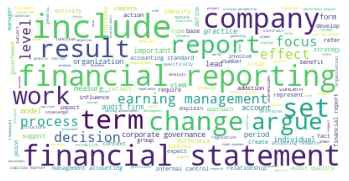

time: 328 ms


In [159]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [193]:
NUM_OF_TOPICS = 50
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 31.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [194]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

time: 26.8 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Unigrams

In [195]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list_of_most_common_surnames', 'll', 'male', 'names', 'org', 'rep', 'shouldn', 've', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.



time: 59.4 s


## Bigrams

In [196]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_list).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 37s


In [197]:
dt3c.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15192 entries, 0 to 15191
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15192 non-null  object
 1   Author           7794 non-null   object
 2   date             14979 non-null  object
 3   title            13546 non-null  object
 4   content_3        15192 non-null  object
 5   content_5        15192 non-null  object
 6   content_10       15192 non-null  object
 7   content_3_lang   15192 non-null  object
 8   content_5_lang   15192 non-null  object
 9   content_10_lang  15192 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
time: 2.98 s


# 4. Non-negative Matrix Factorization (NMF)
- Input: Term-Document matrix, number of topics.
- Output: Two non-negative matrices of the original n words by k topics and those same k topics by the m original documents.

In [198]:
from sklearn.decomposition import NMF

NUM_OF_FEATURES = 5000

# ignore terms that have a document frequency strictly higher than 95%, 
# ignore terms that have a document frequency strictly lower than 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=NUM_OF_FEATURES,
                                   stop_words=stop_list)
tfidf = tfidf_vectorizer.fit_transform(dt3c['content_10'].values.astype(str))

# alpha=0 means no regularization, l1_ratio=.5, the penalty is a combination of L1 and L2
nmf = NMF(n_components=NUM_OF_TOPICS, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
nmf_output = nmf.fit_transform(tfidf)

def show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=NUM_OF_WORDS_IN_EACH_TOPIC):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic_theme,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31,Topic 32,Topic 33,Topic 34,Topic 35,Topic 36,Topic 37,Topic 38,Topic 39,Topic 40,Topic 41,Topic 42,Topic 43,Topic 44,Topic 45,Topic 46,Topic 47,Topic 48,Topic 49,Topic 50
Word 0,firm,audit,social,tax,earning,forecast,disclosure,trading,company,author,environmental,governance,asset,research,auditor,compensation,risk,accrual,internal,student,cost,conservatism,option,manager,fraud,dividend,copyright,debt,goodwill,analyst,management,performance,restatement,pension,government,accountant,csr,return,agent,hospital,standard,client,ethical,chapter,rating,woman,editorial,target,conference,family
Word 1,industry,auditor,accounting,income,announcement,earning,information,announcement,report,article,sustainability,director,income,journal,audit,performance,assessment,discretionary,control,education,product,conservative,exercise,investment,fraudulent,payout,email,covenant,impairment,recommendation,accounting,measure,restate,plan,public,profession,stakeholder,market,principal,patient,accounting,big,ethic,text,credit,gender,editor,acquisition,paper,ownership
Word 2,variable,quality,critical,taxis,firm,error,disclose,investor,financial,manuscript,social,corporate,capital,accounting,independence,executive,bank,flow,auditing,university,production,news,volatility,project,detection,pay,permission,borrower,intangible,information,organisational,information,misstatement,actuarial,sector,professional,social,portfolio,contract,care,financial,partner,moral,author,default,female,horizon,acquirer,presentation,shareholder
Word 3,control,auditing,account,rate,gaap,analyst,voluntary,trade,list,publication,stakeholder,committee,loss,publish,opinion,incentive,factor,abnormal,weakness,teach,customer,conditional,employee,investor,detect,shareholder,download,lender,sfa,coverage,control,organization,announcement,benefit,accountability,accounting,sustainability,model,effort,health,reporting,industry,unethical,review,agency,male,associate,takeover,history,control
Word 4,result,audits,perspective,avoidance,surprise,accuracy,investor,insider,study,citation,emission,shareholder,valuation,account,client,ceo,derivative,earning,external,school,capital,accounting,expense,decision,brainstorm,imputation,copy,contract,asset,brokerage,organisation,study,financial,retirement,local,auditing,report,index,incentive,medical,report,audit,code,topic,issuer,women,accounting,merger,business,owner
Word 5,market,committee,practice,taxation,report,forecasting,report,information,reporting,submission,report,ownership,investment,academic,auditing,pay,business,quality,iaf,academic,supplier,timeliness,eso,information,crime,share,print,equity,write,investor,research,process,error,liability,policy,member,corporate,equity,optimal,nonprofit,gaap,auditor,behavior,edition,downgrade,household,submission,bidder,submission,agency
Word 6,list,partner,theory,taxable,item,news,mandatory,market,industry,submit,corporate,financial,equity,article,judgment,bonus,financial,model,auditor,learn,activity,basu,equity,incentive,financial,repurchase,user,bank,segment,forecast,change,task,turnover,rate,reform,body,assurance,volatility,period,clinical,statement,office,climate,accounting,cra,work,manuscript,bid,accounting,minority
Word 7,measure,big,society,taxpayer,management,revision,news,trader,opinion,text,sustainable,member,net,professor,misstatement,ceos,premium,total,iia,accounting,profit,bad,sfa,managerial,commit,payment,article,financing,acquisition,revision,strategic,decision,irregularity,funding,private,charter,legitimacy,variable,model,physician,adoption,service,responsibility,textbook,cd,career,review,announcement,doctoral,household
Word 8,study,service,process,foreign,future,estimate,firm,volume,corporate,copyright,pollution,exec

time: 3min 44s


In [199]:
# Create Document - Topic Matrix
lda_output = nmf.transform(tfidf)

# column names
topicnames = df_topic_keywords.T.columns
# topicnames = ["Topic" + str(i) for i in range(20)]

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2.13 s


In [200]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(nmf, tfidf, tfidf_vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning:

divide by zero encountered in log

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning:

divide by zero encountered in log

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning:

divide by zero encountered in log



PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
2      -70.658127  -23.674829       1        1  8.707569
31     -52.368645    9.614514       2        1  6.782159
0       19.080936   38.747063       3        1  4.772969
40     -24.804859  -19.299561       4        1  3.866318
12      58.495827   74.667030       5        1  3.490067
34     -45.891243  -58.059502       6        1  3.381114
37      21.647135   76.196541       7        1  3.377988
8       -3.096905    9.342188       8        1  3.020357
14      22.572824  -29.445976       9        1  2.986558
20      90.250031    9.761508      10        1  2.875206
1       40.491219   -4.490702      11        1  2.855637
30     -99.435043    9.462852      12        1  2.811616
4      -12.635139   97.109062      13        1  2.680968
3       72.202789   42.385429      14        1  2.442106
7       29.676260  116.341171      15        1  2.402314
13    -150.731018  -63.731861      16        1  2.377575
6      -23.415068   48.223232      17        1  2.369267
35    -108.436714  -40.618282      18        1  2.280416
23       5.150020  -67.763695      19        1  2.197058
11      14.556836 -122.588615      20        1  2.172731
18      29.812094  179.030899      21        1  1.789849
16     -70.110901   58.382935      22        1  1.759394
9     -170.014160   -8.047050      23        1  1.715290
10     194.315048  -13.844781      24        1  1.667537
38     117.468285   39.779640      25        1  1.620766
15     -27.241358 -107.320129      26        1  1.492223
41      68.139946  -34.315647      27        1  1.485431
19    -134.484879 -103.976540      28        1  1.483958
29     -41.843884  169.152267      29        1  1.344368
27     127.921410  -25.069487      30        1  1.330770
17     -50.156368  104.728493      31        1  1.323939
5      -15.706993  138.107407      32        1  1.296446
46    -187.914948  -39.923336      33        1  1.117628
22      84.427223  107.359932      34        1  0.901295
42    -135.456314   52.512512      35        1  0.896711
24      89.222824  -93.882576      36        1  0.885475
48    -191.202286  -84.612122      37        1  0.850965
47      51.579823 -187.796631      38        1  0.846629
21     173.570724   57.723759      39        1  0.803896
43     -96.590652  -81.919128      40        1  0.796346
44     141.405884  -61.027679      41        1  0.795906
25      93.101501  154.184387      42        1  0.775535
45     -92.681305 -146.714233      43        1  0.755234
36     210.980225  -42.115643      44        1  0.703390
49      -7.663980 -159.734177      45        1  0.695971
33     131.579636   96.241722      46        1  0.677869
39     112.633682 -147.468826      47        1  0.660130
32      51.788021  -79.329628      48        1  0.613073
28    -110.197807  129.993423      49        1  0.599982
26    -213.424805    9.062606      50        1  0.463999, topic_info=                      Term         Freq        Total Category  logprob  \
347                  audit  1133.000000  1133.000000  Default  30.0000   
3932                  risk   865.000000   865.000000  Default  29.0000   
204                analyst   715.000000   715.000000  Default  28.0000   
1909              forecast   605.000000   605.000000  Default  27.0000   
4483                   tax   680.000000   680.000000  Default  26.0000   
676                 client   602.000000   602.000000  Default  25.0000   
1460               earning   870.000000   870.000000  Default  24.0000   
351                auditor   865.000000   865.000000  Default  23.0000   
1319            disclosure   654.000000   654.000000  Default  22.0000   
1614         environmental   525.000000   525.000000  Default  21.0000   
50                 accrual   507.000000   507.000000  Default  20.0000   
1402              dividend   394.000000   394.000000  Default  19.0000   
2436              internal   47

time: 8.07 s


In [201]:
print(lda_output.shape)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape)

(15192, 50)
(15192, 1)
time: 20.6 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [202]:
column_names = ['file_path', 'content_10'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'content_10']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 79.6 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [203]:
doc_topic_df.columns = column_names

time: 613 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [204]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15192 entries, 0 to 15191
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15192 non-null  object 
 1   content_10  15192 non-null  object 
 2   Topic 1     15192 non-null  float64
 3   Topic 2     15192 non-null  float64
 4   Topic 3     15192 non-null  float64
 5   Topic 4     15192 non-null  float64
 6   Topic 5     15192 non-null  float64
 7   Topic 6     15192 non-null  float64
 8   Topic 7     15192 non-null  float64
 9   Topic 8     15192 non-null  float64
 10  Topic 9     15192 non-null  float64
 11  Topic 10    15192 non-null  float64
 12  Topic 11    15192 non-null  float64
 13  Topic 12    15192 non-null  float64
 14  Topic 13    15192 non-null  float64
 15  Topic 14    15192 non-null  float64
 16  Topic 15    15192 non-null  float64
 17  Topic 16    15192 non-null  float64
 18  Topic 17    15192 non-null  float64
 19  Topic 18    15192 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [205]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

time: 18 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [206]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15192 entries, 0 to 15191
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15192 non-null  object 
 1   content_10  15192 non-null  object 
 2   Topic 1     15192 non-null  float64
 3   Topic 2     15192 non-null  float64
 4   Topic 3     15192 non-null  float64
 5   Topic 4     15192 non-null  float64
 6   Topic 5     15192 non-null  float64
 7   Topic 6     15192 non-null  float64
 8   Topic 7     15192 non-null  float64
 9   Topic 8     15192 non-null  float64
 10  Topic 9     15192 non-null  float64
 11  Topic 10    15192 non-null  float64
 12  Topic 11    15192 non-null  float64
 13  Topic 12    15192 non-null  float64
 14  Topic 13    15192 non-null  float64
 15  Topic 14    15192 non-null  float64
 16  Topic 15    15192 non-null  float64
 17  Topic 16    15192 non-null  float64
 18  Topic 17    15192 non-null  float64
 19  Topic 18    15192 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [207]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

(15192, 50)
[0.02168927 0.         0.0220033  0.         0.         0.
 0.         0.00293064 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00760686 0.         0.         0.00021219
 0.         0.         0.         0.         0.         0.
 0.00599616 0.04774042 0.         0.         0.         0.
 0.         0.         0.         0.         0.01278363 0.
 0.         0.         0.         0.         0.0010523  0.
 0.         0.        ]
time: 9.26 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 4.4. Prepare pre-trained model
### 4.4.1. Save the model
Save the model to use as pre-trained model on the https://simple-recommender.herokuapp.com/ website.

In [208]:
import pickle

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

pickle.dump( norms, open( "nmf_model__norms.pkl", "wb" ) )
pickle.dump( topic_array, open( "nmf_model__topic_array.pkl", "wb" ) )
df_topic_keywords.to_pickle('nmf_model__df_topic_keywords.pkl')
pickle.dump( doc_topic_df, open( "nmf_model__doc_topic_df.pkl", "wb" ) )
pickle.dump( nmf, open( "nmf_model__lda_model.pkl", "wb" ) )
pickle.dump( tfidf_vectorizer, open( "nmf_tfidf_vectorizer.pkl", "wb" ) )
pickle.dump( stop_list, open( "nmf_model__stop_list.pkl", "wb" ) )



/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 1.25 s


### 4.4.2. Add Title, Author, metadata to core model
Use useful data from RELAVENT_DATA.xlsx

In [209]:
x = dt3c.copy()
# Paper Name, Author Name(s), Year and Journal
print(x['date'].isna().sum())
x['date'] = x['date'].fillna(0)
print(x['date'].isna().sum())

doc_topic_df['year'] = x['date']

213
0
time: 67.5 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [210]:
def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

x['Author'] = x['Author'].fillna('-')
x['authors'] = x['Author'].apply(combine_authors)

doc_topic_df['authors'] = x['authors']

time: 21.6 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [211]:
print(x['title'].isna().sum())
x['title'] = x['title'].fillna('-')
print(x['title'].isna().sum())

doc_topic_df['title'] = x['title']

1646
0
time: 6.64 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [212]:
def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

doc_topic_df['journal'] = x['file_path'].apply(journal_name)
doc_topic_df['journal'].head(5)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0    AH
1    AH
2    AH
3    AH
4    AH
Name: journal, dtype: object

time: 63.9 ms


In [213]:
rt = pd.read_excel('/Users/farukcankaya/FC/GoogleDrive/DATA_RELEVANT.xlsx')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:312: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/xlrd/xlsx.py:266: DeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.it

time: 22.2 s


In [214]:
rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt['file_path'][0]))][0]]['Title']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'The effect of system characteristics, stage of adoption, and experience on institutional explanations for ERP systems choice'

time: 11.7 ms


In [215]:
titles = []
for i in range(0, len(dt3c['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    titles.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Title'])
  else:
    titles.append(dt3c['title'][i])
      

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 2min 49s


In [216]:
pickle.dump( doc_topic_df, open( "nmf_model__doc_topic_df.pkl", "wb" ) )

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 885 ms


In [217]:
# LOAD pre-trained model if you just want to make prediction here.
"""
norms     = pickle.load( open( "nmf_model__norms.pkl", "rb" ) )
topic_array     = pickle.load( open( "nmf_model__topic_array.pkl", "rb" ) )
df_topic_keywords = pickle.load( open( "nmf_model__df_topic_keywords.pkl", "rb" ) )
doc_topic_df = pickle.load( open( "nmf_model__doc_topic_df.pkl", "rb" ) )
nmf = pickle.load( open( "nmf_model__lda_model.pkl", "rb" ) )
tfidf_vectorizer   = pickle.load( open( "nmf_tfidf_vectorizer.pkl", "rb" ) )
stop_list     = pickle.load( open( "nmf_model__stop_list.pkl", "rb" ) )
"""

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



'\nnorms     = pickle.load( open( "nmf_model__norms.pkl", "rb" ) )\ntopic_array     = pickle.load( open( "nmf_model__topic_array.pkl", "rb" ) )\ndf_topic_keywords = pickle.load( open( "nmf_model__df_topic_keywords.pkl", "rb" ) )\ndoc_topic_df = pickle.load( open( "nmf_model__doc_topic_df.pkl", "rb" ) )\nnmf = pickle.load( open( "nmf_model__lda_model.pkl", "rb" ) )\ntfidf_vectorizer   = pickle.load( open( "nmf_tfidf_vectorizer.pkl", "rb" ) )\nstop_list     = pickle.load( open( "nmf_model__stop_list.pkl", "rb" ) )\n'

time: 2.4 ms


## 4.5. Measure similarity

In [218]:
def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

time: 2.76 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [219]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwords
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = tfidf_vectorizer.transform(mytext_3)
    

    # LDA Transform
    topic_probability_scores = nmf.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 930 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## 4.6 Make single prediction

In [220]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = TAR_6)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic
['performance', 'measure', 'information', 'organization', 'study', 'process', 'task', 'decision', 'organizational', 'budget', 'employee', 'customer', 'control', 'participant', 'evaluation', 'research', 'level', 'model', 'result', 'strategic']

prob_scores
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02309522 0.00110017 0.
 0.         0.         0.         0.         0.         0.00054982
 0.         0.         0.         0.         0.         0.
 0.         0.07758921 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
shape of prob_scores: (50,)

Try to make recommendation. Inputs:
- prob_scores
- topic_array: (15192, 50) prob. distribution of topics for each document that is calculated by LDA
- doc_topic_df: (15192, 56) that is actually output of 

file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 407 ms


# 5. Calculate Accuracy
## 5.1. Calculate Top-5 Accuracy

In [221]:
from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, n=5):
    co_dists = compute_dists(top_vec, topic_array)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
topic, prob_scores = predict_topic(text = TAR_6)

topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df)

rec_top_1 = recs[topic_columns].head(1).values

print('rec_top_1:')
print(rec_top_1)
print('prob_scores:')
print(prob_scores.flatten())
print('cosine_similarity:')
print(cosine_similarity(rec_top_1,prob_scores))

rec_top_1:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.02369179 0.00047109 0.
  0.         0.         0.         0.         0.         0.00455159
  0.         0.         0.         0.         0.         0.
  0.         0.07191841 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]
prob_scores:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02309522 0.00110017 0.
 0.         0.         0.         0.         0.         0.00054982
 0.         0.         0.         0.         0.         0.
 0.         0.07758921 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [222]:
recs['file_path']

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



849      /Users/farukcankaya/Google Drive/AllPapers/11_BAR/433_BAR.pdf
7632        /Users/farukcankaya/Google Drive/AllPapers/1_TAR/6_TAR.pdf
13270    /Users/farukcankaya/Google Drive/AllPapers/12_MAR/381_MAR.pdf
7608      /Users/farukcankaya/Google Drive/AllPapers/1_TAR/482_TAR.pdf
1055     /Users/farukcankaya/Google Drive/AllPapers/11_BAR/544_BAR.pdf
Name: file_path, dtype: object

time: 4.51 ms


## 5.2. Calculate Top 1,5,20,100 Accuracy

In [223]:
def accuracy_n(file_path, data, top_n=[1]):
  topic, prob_scores = predict_topic([data])

  topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)

time: 1.47 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [224]:
## PARALLEL TEST
xx = dt.copy().drop(unknown_lang_indexes)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
xx.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-218-cb9b074fa402>:7: RuntimeWarning:

invalid val

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15193 entries, 0 to 15750
Columns: 2445 entries, file_path to acc_top_100
dtypes: float64(330), int64(337), object(1778)
memory usage: 283.5+ MB
time: 13min 10s


In [225]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

Top-1 Score:0.29987494240768775
Top-5 Score:0.4895017442243138
Top-10 Score:0.5733561508589482
Top-20 Score:0.6621470414006451
Top-50 Score:0.7654182847363917
Top-100 Score:0.8414401369051537
time: 16.3 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

